# **Deep learning for image analysis with Python**

#### Fernando Cervantes, Systems Analyst I, Imaging Solutions, Research IT
#### fernando.cervantes@jax.org    (slack) @fernando.cervantes

Use ssh, or create a tunnel using MobaXTerm, or Putty to connect to the GCP<br>
**ssh -nNfg -L8888:computenodename:8080 student-##@###.###.###.### <br>**
_To be used only during the workshop only. To login into JAX HPC use ssh as usual_<br>

Run the singularity container using the following command:<br>
**singularity run --nv --env CUDA_VISIBLE_DEVICES=0 --bind /fastscratch/data/:/mnt/data/:ro,/fastscratch/models/:/mnt/models/:ro /fastscratch/pytorch_jupyter.sif -m jupyterlab --no-browser --ip=$(hostname -i)**<br>
- **--nv** tells Singularity to use the NVIDIA drivers and allows us to use the GPUs inside the container
- **--env CUDA_VISIBLE_DEVICES=0** sets an environment variable that specifies what GPU device is going to be used by PyTorch
- **--bind /fastscratch/data/:/mnt/data/:ro** bind the location of the datasets to be visible inside the container (under the path _/mnt/data/_)

Copy the URL and paste into the search bar of your browser.<br>
If jupyter asks for a password setup, use the token from the URL that you copied and use as password: **student-#**<br>
The token looks something like: http://some-ip:8888/lab?token= **A-long-alphanumeric-string**

## 5 Implement the training loop

### 5.1 _Data preparation_

Using the *torchvision* library, pull the CIFAR 100 dataset.<br>
We'll need to transform images from this dataset from PIL Images to PyTorch tensors.

In [7]:
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor

cifar_data = CIFAR100(root='/home/cervaf/data', #'/mnt/data',
                             download=False,
                             train=True,
                             transform=ToTensor()
                            )

In [8]:
from torch.utils.data import DataLoader

cifar_loader = DataLoader(cifar_data,
                        batch_size=128,
                        shuffle=True,
                        pin_memory=True
                        )

In [9]:
print('Dataset size:', len(cifar_data))
print('DataLoader size:', len(cifar_loader))

Dataset size: 50000
DataLoader size: 391


Plot some of the CIFAR labeled examples. Check [here](https://huggingface.co/datasets/cifar100) the labels

torch.Size([3, 32, 32])


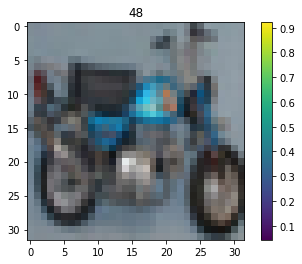

In [10]:
import matplotlib.pyplot as plt

x, t = cifar_data[10000]
print(x.size())
plt.imshow(x.permute(1, 2, 0))
plt.title(t)
plt.colorbar()
plt.show()

***
### 5.2 _Network preparation_

Implement a Residual Network ([ResNet](https://arxiv.org/pdf/1512.03385.pdf))<br>
The torchvision module from pytorch provides models that have been pre-trained with the ImageNet dataset (1.2 million images natural images for training, with 1000 different classes)<br>
This is usefull for *transfer the learning* to other applications, or use those as *warmed-up* models, instead of random initialization of the weights.<br>
However, the architecture is fixed to work with input images of $224\times224$ pixels with $3$ channels (RBG), and output $1000$ classes.<br>
For our example with the CIFAR 100 dataset, that is composed by images of $32\times32$ pixesl in RGB, and only has $100$ classes, thre pre-trained models won't be usefull.


In [50]:
import torchvision.models as models

In [51]:
print(models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Lets use our LeNet network that we implemented as a custom pytorch Module

In [11]:
import torch
import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.sub_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.sub_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc_2 = nn.Linear(in_features=120, out_features=84)
        self.fc_3 = nn.Linear(in_features=84, out_features=num_classes)
        
        self.act_fn = nn.ReLU()

    def forward(self, x):
        # Apply convolution layers to extract feature maps with image context
        fx = self.act_fn(self.conv_1(x))
        fx = self.sub_1(fx)
        
        fx = self.act_fn(self.conv_2(fx))
        fx = self.sub_2(fx)
        
        # Flatten the feature maps to perform linear operations
        fx = fx.view(-1, 16*5*5)
        
        fx = self.act_fn(self.fc_1(fx))
        fx = self.act_fn(self.fc_2(fx))
        y = self.fc_3(fx)
        
        return y

Alternatively, we can define the layers of our network using the Sequential function to reduce the code in the forward pass

In [73]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        self.layer_fc = nn.Sequential(
            nn.Linear(in_features=5*5*16, out_features=120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84, bias=True),
            nn.ReLU(),        
            nn.Linear(in_features=84, out_features=num_classes, bias=True)
        )

    def forward(self, x):    
        fx = self.layer_1(x) 
        fx = self.layer_2(x)

        fx = fx.flatten()

        logits = self.layer_fc(x)
        
        return logits


Or even have all layers as a single operation

In [74]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(in_features=5*5*16, out_features=120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84, bias=True),
            nn.ReLU(),        
            nn.Linear(in_features=84, out_features=num_classes, bias=True)
        )

    def forward(self, x):
        logits = self.layers(x)
        
        return logits

***
### 5.3 _Definition of the optimization problem_

Define the loss function and the optimizer, and test it.

In [237]:
import torch.optim as optim

net = LeNet(in_channels=3, num_classes=100)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    params=net.parameters(),
    lr=1e-3
)

This is a single training step !

In [246]:
%%time
optimizer.zero_grad()

x, t = cifar_data[0]

y = net(x.view(1, 3, 32, 32))

loss = criterion(y, torch.tensor([t]))

loss.backward()

optimizer.step()

CPU times: user 137 ms, sys: 2.98 ms, total: 140 ms
Wall time: 62.2 ms


In [224]:
print('Loss %f' % loss)

Loss 3.525292


***
### Setup for training in GPU

In [248]:
net = LeNet(in_channels=3, num_classes=100)
criterion = nn.CrossEntropyLoss()

# Move our network to the GPU memory, as well as our criterion
net.cuda()
criterion.cuda()

# Define the optimizer after we have moved the network to the GPU, so the update is perfomred in GPU momory
optimizer = optim.Adam(
    params=net.parameters(),
    lr=1e-3
)

In [230]:
%%time
x, t = cifar_data[1]

optimizer.zero_grad() # Clean the gradient accumulator

# Move the input to GPU memory before feeding the network with it
y = net(x.view(1, 3, 32, 32).cuda())

# Move the target as well to compute the loss on the GPU
loss = criterion(y, torch.tensor([t]).cuda())

loss.backward()

optimizer.step()

CPU times: user 3.91 ms, sys: 2 µs, total: 3.91 ms
Wall time: 4.49 ms


***
### 5.4 _Implement the training loop_

The DataLoader class in PyTorch is usefull to split the dataset into batches.<br>
It also convert the individual targets to tensors that can be used directly by the loss function

#### Run one *epoch* of training

In [176]:
%%time
trn_loss = []
for i, (x, t) in enumerate(cifar_loader):
    optimizer.zero_grad()
    
    x = x.cuda()
    t = t.cuda()
    
    y = net(x)
    
    loss = criterion(y, t)
    
    loss.backward()
    
    trn_loss.append(loss.item())
    
    optimizer.step()
    
    if i % 100 == 0:
        print('[%i] Loss %.8f' % (i, loss))

[0] Loss 4.61597776
[100] Loss 4.38838720
[200] Loss 4.24142933
[300] Loss 4.01496029
Epoch computed in 15.6036 seconds


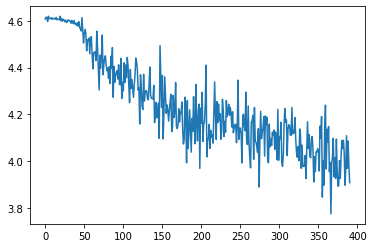

In [251]:
plt.plot(trn_loss)

#### Run several *epochs*

In [252]:
%%time
trn_loss = []
net.train()

for e in range(10):
    avg_loss = 0
    for i, (x, t) in enumerate(cifar_loader):
        optimizer.zero_grad()

        x = x.cuda()
        t = t.cuda()
        
        y = net(x)

        loss = criterion(y, t)

        loss.backward()
        
        avg_loss += loss.item()
        trn_loss.append(loss.item())

        optimizer.step()
    
    avg_loss = avg_loss / len(cifar_loader)
    print('[Epoch %02i] %.8f' % (e, avg_loss))

[Epoch 00] 3.81770386
[Epoch 01] 3.56330176
[Epoch 02] 3.37301423
[Epoch 03] 3.23973070
[Epoch 04] 3.15810546
[Epoch 05] 3.09302752
[Epoch 06] 3.03700743
[Epoch 07] 2.98061341
[Epoch 08] 2.93615236
[Epoch 09] 2.88925683
CPU times: user 4min 53s, sys: 1.08 s, total: 4min 54s
Wall time: 2min 33s


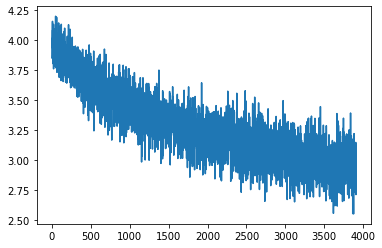

In [179]:
plt.plot(trn_loss)

In [255]:
%%time
trn_loss = []
trn_acc = []

net.train()

for e in range(10):
    avg_loss = 0
    avg_acc = 0
    
    for i, (x, t) in enumerate(cifar_loader):
        optimizer.zero_grad()

        x = x.cuda()
        t = t.cuda()
        
        y = net(x)

        loss = criterion(y, t)
        
        loss.backward()
        
        curr_acc = torch.sum(y.argmax(dim=1) == t).item()
        
        avg_loss += loss.item()
        avg_acc += curr_acc
        
        trn_loss.append(loss.item())
        trn_acc.append(curr_acc / x.size(0))

        optimizer.step()
    
    avg_loss = avg_loss / len(cifar_loader)
    avg_acc = avg_acc / len(cifar_data)
    print('[Epoch %02i] %.8f, acc %.4f %%' % (e, avg_loss, avg_acc))

[Epoch 00] 2.57480830, acc 0.3429 %
[Epoch 01] 2.55356254, acc 0.3467 %
[Epoch 02] 2.53715809, acc 0.3512 %
[Epoch 03] 2.52499525, acc 0.3528 %
[Epoch 04] 2.50940348, acc 0.3584 %
[Epoch 05] 2.48814400, acc 0.3626 %
[Epoch 06] 2.47072009, acc 0.3648 %
[Epoch 07] 2.45626509, acc 0.3689 %
[Epoch 08] 2.44863286, acc 0.3690 %
[Epoch 09] 2.43216655, acc 0.3732 %
CPU times: user 4min 52s, sys: 918 ms, total: 4min 53s
Wall time: 2min 32s


#### Save the trained model (checkpoint)

In [180]:
torch.save(net.state_dict(), '/mnt/models/lenet_20220420.pth')

***
#### Test the trained model
Use the test partition of the CIFAR 100 dataset

In [146]:
cifar_tst_dataset = CIFAR100(root='/home/cervaf/data', download=False, train=False, transform=ToTensor())
cifar_tst_loader = DataLoader(cifar_tst_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [147]:
import sklearn.metrics
import numpy as np

In [256]:
# Load the checkpoint
state_dict = torch.load('lenet_700epochs_20220519.pth')

In [257]:
for k in state_dict.keys():
    print(k)

conv_1.weight
conv_1.bias
conv_2.weight
conv_2.bias
fc_1.weight
fc_1.bias
fc_2.weight
fc_2.bias
fc_3.weight
fc_3.bias


In [258]:
# Create a new network object
test_net = LeNet(in_channels=3, num_classes=100)

In [259]:
# Load the trained weights
test_net.load_state_dict(state_dict)

<All keys matched successfully>

#### Test the accuracy of the trained network

In [260]:
tst_avg_loss = 0
tst_avg_acc = 0
tst_avg_acc_5 = 0
tst_avg_acc_10 = 0

test_net.cuda()
test_net.eval()

for i, (x, t) in enumerate(cifar_tst_loader):
    with torch.no_grad():
        x = x.cuda()
        t = t.cuda()
        
        y = test_net(x)
        loss = criterion(y, t)
    
    tst_avg_loss += loss.item()

    tst_avg_acc += sklearn.metrics.accuracy_score(t.cpu().numpy(), y.cpu().argmax(dim=1).numpy(), normalize=False)
    tst_avg_acc_5 += sklearn.metrics.top_k_accuracy_score(t.cpu().numpy(), y.cpu().numpy(), k=5, labels=np.arange(100), normalize=False)
    tst_avg_acc_10 += sklearn.metrics.top_k_accuracy_score(t.cpu().numpy(), y.cpu().numpy(), k=10, labels=np.arange(100), normalize=False)

tst_avg_loss = tst_avg_loss / len(cifar_tst_loader)
tst_avg_acc = tst_avg_acc / len(cifar_tst_dataset) * 100
tst_avg_acc_5 = tst_avg_acc_5 / len(cifar_tst_dataset) * 100
tst_avg_acc_10 = tst_avg_acc_10 / len(cifar_tst_dataset) * 100
print('Average test loss %.8f, average accuracy %.2f %%, average accuracy@5 %.2f %%, average accuracy@10 %.2f %%' % (tst_avg_loss, tst_avg_acc, tst_avg_acc_5, tst_avg_acc_10))

Average test loss 3.76036327, average accuracy 27.34 %, average accuracy@5 55.42 %, average accuracy@10 68.21 %


Check with a sample image from the training set

In [261]:
x, t = cifar_data[100]
x = x.cuda()
y = test_net(x.view(1, 3, 32, 32))

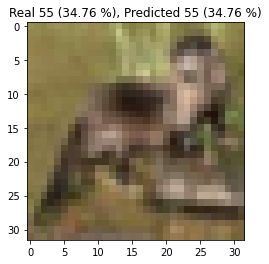

In [262]:
plt.imshow(x.cpu().permute(1, 2, 0))
plt.title('Real %i (%.2f %%), Predicted %i (%.2f %%)' % (t, torch.softmax(y, dim=1)[0, t].item() * 100, y.cpu().argmax(dim=1)[0].item(), torch.softmax(y, dim=1).max().item() * 100))
plt.show()

Check the labels [here](https://huggingface.co/datasets/cifar100)

Check one image from the test set

In [263]:
x, t = cifar_tst_dataset[5550]
x = x.cuda()
y = test_net(x.view(1, 3, 32, 32))

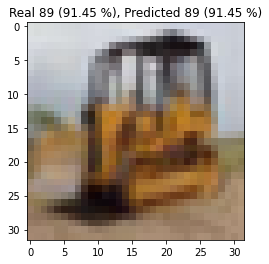

In [264]:
plt.imshow(x.cpu().permute(1, 2, 0))
plt.title('Real %i (%.2f %%), Predicted %i (%.2f %%)' % (t, torch.softmax(y, dim=1)[0, t].item() * 100, y.cpu().argmax(dim=1)[0].item(), torch.softmax(y, dim=1).max().item() * 100))
plt.show()